# Client Churn Prediction

 *  TopBank is a bank company that operates primarily in Europe. TopBank's main product is a bank account where the custumer doesn't have any cost in the first 12 months.

* However, the client needs to rehire the bank for the upcoming 12 months after the free trial expires or everytime this new 12 months hired also expires.


* Recently, the Analytics team noticed that the churn rate of clients is steadily increasing


* Worried about this new growing rate of churn clients, the Data Science team has the challenge to create an action plan to reduce the churn rate of clients




# The Challenge

 As a Data Science Consultant, you need to create an action plan to decrease the number of churn customers and show the financial return on your solution.
At the end of your consultancy, you need to deliver to the TopBank CEO a model in production, which will receive a customer base via API and return that same base with an extra column with the probability of each customer going into churn.
In addition, you will need to provide a report reporting your model's performance and the financial impact of your solution. Questions that the CEO and the Analytics team would like to see in their report:

* What is Top Bank's current Churn rate? How does it vary monthly?

* What is the performance of the model in classifying customers as churns?

* What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

A possible action to prevent the customer from churning is to offer a discount coupon, or some other financial incentive for him to renew his contract for another 12 months.

* Which customers would you give the financial incentive to and what would that amount be, in order to maximize ROI (Return on Investment). Recalling that the sum of incentives for each client cannot exceed EUR 10.000,00.

# 0.0 IMPORTS

In [45]:
import re
import inflection

import numpy   as np
import pandas  as pd
import seaborn as sns
import scipy as scp

import matplotlib.pyplot as plt

from sklearn.metrics       import mean_absolute_error, mean_squared_error


# models
from sklearn.linear_model  import LogisticRegression
from sklearn.linear_model  import LinearRegression


from yellowbrick.classifier  import ROCAUC, ClassificationReport, ConfusionMatrix

from IPython.display         import HTML

from sklearn.model_selection import cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve


import numpy as np

from boruta import BorutaPy

from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import RobustScaler
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestRegressor

## 0.1 Helper Functions

In [46]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()


# Function to plot a dataframe with percentage of categorical columns values
def df_percent( col_name ):
    a = pd.DataFrame( cat_attributes[col_name].value_counts() ).reset_index()
    b = pd.DataFrame( cat_attributes[col_name].value_counts( normalize=True )*100 ).reset_index()
    df = pd.merge( a, b, how='left', on='index' )
    df.columns = [col_name,'absolute', 'percentage']
    return df
    


    
# Model's performance function
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance


# Model's performance on test set function
def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df
    

# Model's performance function
def scores( model_name ,y_true, yhat ):
    
    # metrics
    accuracy = accuracy_score( y_true, yhat )
    precision = precision_score( y_true, yhat )
    recall = recall_score( y_true, yhat )
    f1 = f1_score( y_true, yhat )
    roc_auc = roc_auc_score( y_true, yhat )
    
    # Create a dataframe with metrics
    metrics = pd.DataFrame( {'Accuracy': accuracy,
                             'Precision': precision,
                             'recall': recall,
                             'f1_score': f1,
                             'roc_auc': roc_auc
                            }, index=[model_name]  )
    return metrics



# Plot ROC AUC CURVE
def roc_auc_curve( model, x_train, y_train, x_test, y_test ):

    # Instantiate the visualizer with the classification model

    visualizer = ROCAUC( model, classes=["not_churn", "churn"] )

    visualizer.fit( x_train, y_train )        # Fit the training data to the visualizer
    visualizer.score( x_test, y_test)        # Evaluate the model on the test data
    visualizer.show();                       # Finalize and show the figure

    
    
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean(np.abs(( y - yhat ) / y))


def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = scp.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )    
    
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [7]:
#jupyter_settings()
#pd.set_option('display.float_format', lambda x: '%.2f' % x)
#warnings.filterwarnings('ignore')

## 0.2 Load Data

In [8]:
 df_raw = pd.read_csv( '../data/raw/churn.csv' )

# 1.0 DATA DESCRIPTION

In [9]:
df1 = df_raw.copy()

* **RowNumber**: Row Number
* **CustomerID**: Customer Identification has no effect on customer leaving the bank.
* **Surname:** Customer's surname
* **CreditScore:** The customer's Credit score for the consumer market.
* **Geography:** The country where the customer live.
* **Gender:** Customer's gender
* **Age:** Customer's age.
* **Tenure:** Number of years the customer has remained with the active account.
* **Balance:** Monetary value the customer has in their bank account.
* **NumOfProducts:** The number of products purchased by the customer at the bank.
* **HasCrCard:** Indicates whether the customer has a credit card.
* **IsActiveMember:** Indicates whether the customer made at least one bank account transaction within 12 months.
* **EstimateSalary:** Estimate of the client's salary.
* **Exited:** whether or not the customer left the bank. (0=No,1=Yes) **Target variable.**

In [10]:
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1.1 Rename columns

In [11]:
cols_old = df1.columns

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map ( snakecase, cols_old ) )

df1.columns = cols_new

df1.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.2 Data Dimension

In [12]:
print('Number of rows: {}'.format( df1.shape[0] ) )
print('Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 10000
Number of columns: 14


## 1.3 Data Types

In [13]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Check NA

In [14]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Descriptve Statistical

In [15]:

# Change categorical variable 1 and 0 into 'yes' and 'no'

col_str = ['exited', 'has_cr_card', 'is_active_member' ]

for col in col_str:
    df1[col] = df1[col].astype('str') 

for col in col_str:
    df1[col] = df1[col].apply( lambda x: 'yes' if x=='1' else 'no')

In [16]:
# Isolate numerical and categorical variables
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( include=['object'] )

### 1.5.1 Numerical Attributes

In [17]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min , max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.min() - x.max() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['Atribbutes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'Std', 'Skew', 'Kurtosis']
m

,Atribbutes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,row_number,1.00,10000.00,-9999.00,5.000500e+03,5.000500e+03,2886.751332,0.000000,-1.200000
1,customer_id,15565701.00,15815690.00,-249989.00,1.569094e+07,1.569074e+07,71932.589224,0.001149,-1.196113
2,credit_score,350.00,850.00,-500.00,6.505288e+02,6.520000e+02,96.648466,-0.071607,-0.425726
3,age,18.00,92.00,-74.00,3.892180e+01,3.700000e+01,10.487282,1.011320,1.395347
4,tenure,0.00,10.00,-10.00,5.012800e+00,5.000000e+00,2.892030,0.010991,-1.165225
5,balance,0.00,250898.09,-250898.09,7.648589e+04,9.719854e+04,62394.285254,-0.141109,-1.489412
6,num_of_products,1.00,4.00,-3.00,1.530200e+00,1.000000e+00,0.581625,0.745568,0.582981
7,estimated_salary,11.58,199992.48,-199980.90,1.000902e+05,1.001939e+05,57507.617221,0.002085,-1.181518


### 1.5.2 Categorical Attributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

surname             2932
geography              3
gender                 2
has_cr_card            2
is_active_member       2
exited                 2
dtype: int64

In [19]:
df_percent( 'geography')

,geography,absolute,percentage
0,France,5014,50.14
1,Germany,2509,25.09
2,Spain,2477,24.77


In [20]:
df_percent( 'gender')

,gender,absolute,percentage
0,Male,5457,54.57
1,Female,4543,45.43


In [21]:
df_percent( 'has_cr_card')

,has_cr_card,absolute,percentage
0,yes,7055,70.55
1,no,2945,29.45


In [22]:
df_percent( 'is_active_member')

,is_active_member,absolute,percentage
0,yes,5151,51.51
1,no,4849,48.49


In [23]:
df_percent( 'exited')

,exited,absolute,percentage
0,no,7963,79.63
1,yes,2037,20.37


# 2.0 FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

In [25]:
### Feature ideias
# tenure_year'
# 'age_tenure_year'
# 'cred_tenure_year'
# 'cred_age'
# 'amount' = estimated_salary + balance
# 'amount_credit' = amount / credict_scote
# amount / tenure_year
# amount / products
# credit score / products
# balance / tenure_year
# products - credit card
# products * credit card

## 2.1. Hypotheses Mindmap

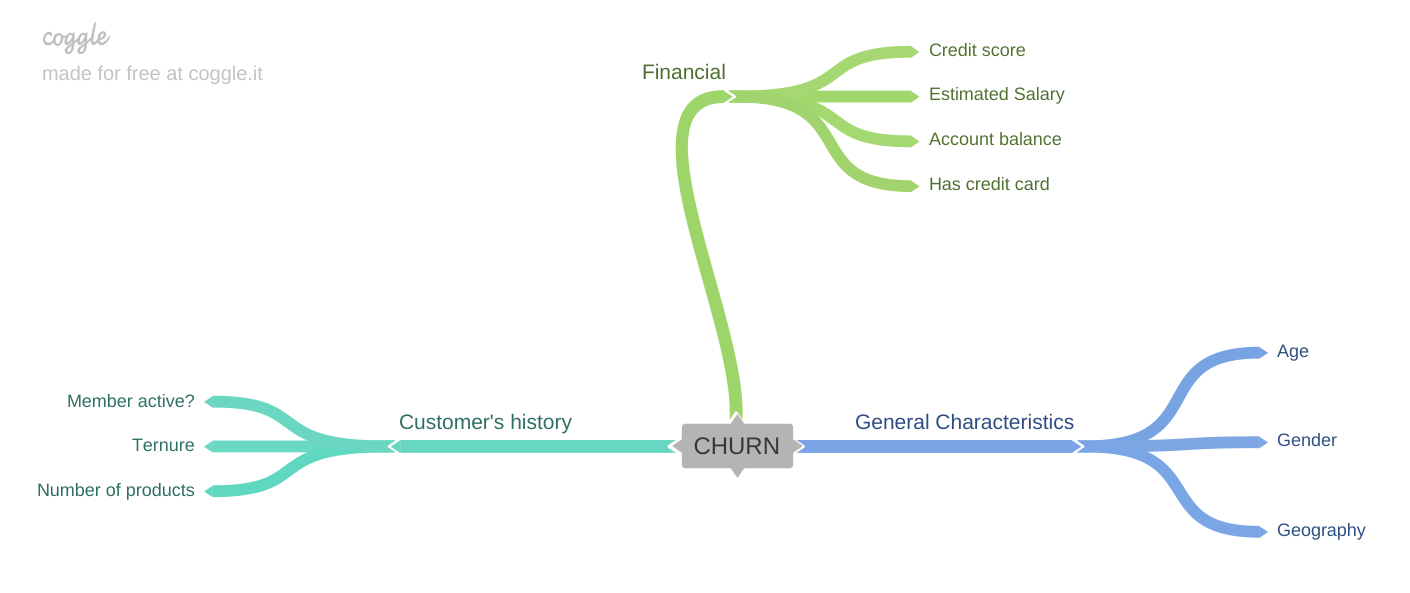

In [26]:
from IPython.display import Image
Image("../references/churn-coggle.png")

## 2.2. Hypotheses

Hypotheses List

* **H1** - Younger customers tend to leave the bank
* **H2** - Customers with fewer products tend to leave the bank easier
* **H3** - Customers without credit cards are more likely to churn
* **H3** - People with 0 balance (account monetary value) have a higher chance of churn
* **H4** - Active customers in the last 12 months (is_active_member) have less chance of churn
* **H5** - Salary below average (estimated_salary) greater chance of churn
* **H6** - The lower the credit_score the greater the chance of churn
* **H7** - Customers with a few years of banking (ternure) are more likely to churn
* **H8** - Men are more likely to Churn
* **H9** - Customers with larger account amount have less chance of churn
* **H10** - Young customers with little balance are prone to churn


## 2.3 Create new Features

In [27]:
# Credit score per age
df2['credit_score_age'] = df2['credit_score'] / df2['age']

# amount = estimated_salary + balance
df2['amount'] = df2['estimated_salary'] + df2['balance']

# Credit score per product
df2['credit_score_product'] = df2['credit_score'] / df2['num_of_products']

# balance per age
df2['balance_age'] = df2['balance'] / df2['age']

# balance per number of products
df2['balance_product'] = df2['balance'] / df2['num_of_products']

# Mean Salary
mean_salary = np.mean( df2['estimated_salary'].values)
df2['mean_salary'] = df2['estimated_salary'].apply( lambda x: 'below average' if x < mean_salary else 'average' if x==mean_salary else 'above average'  )

# Balance scale
df2['balance_scale'] = df2['balance'].apply( lambda x: 'zero' if x==0 else 'normal_balance' if (x > 0) & (x <= 76485.89) else 'high_balance' )

In [28]:
df2.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,credit_score_age,amount,credit_score_product,balance_age,balance_product,mean_salary,balance_scale
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,yes,yes,101348.88,yes,14.738095,101348.88,619.000000,0.000000,0.000000,above average,zero
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,no,yes,112542.58,no,14.829268,196350.44,608.000000,2044.094146,83807.860000,above average,high_balance
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,yes,no,113931.57,yes,11.952381,273592.37,167.333333,3801.447619,53220.266667,above average,high_balance
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,no,no,93826.63,no,17.923077,93826.63,349.500000,0.000000,0.000000,below average,zero
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,yes,yes,79084.10,no,19.767442,204594.92,850.000000,2918.856279,125510.820000,below average,high_balance


# 3.0 VARIABLE SELECTION

In [29]:
df3 = df2.copy()

In [30]:
df3 = df3.drop( ['row_number','surname'], axis=1 )

# 4.0 EXPLORATORY DATA ANALYSIS

In [31]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

The target variable is **unbalanced**: **churn** clients are **20%**; **not churn** are **80%**

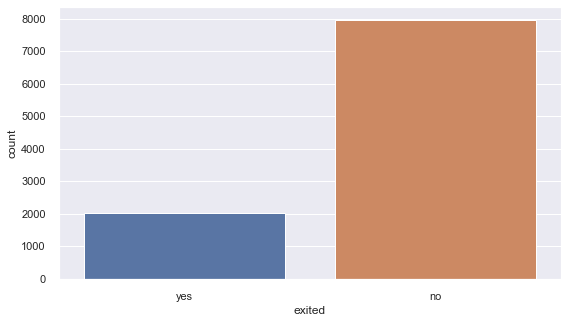

In [32]:
#See the visual distribution of the target variable

plt.rcParams['figure.figsize'] = [9, 5]

sns.countplot(x='exited', data=df1);

### 4.1.2. Numerical Variables

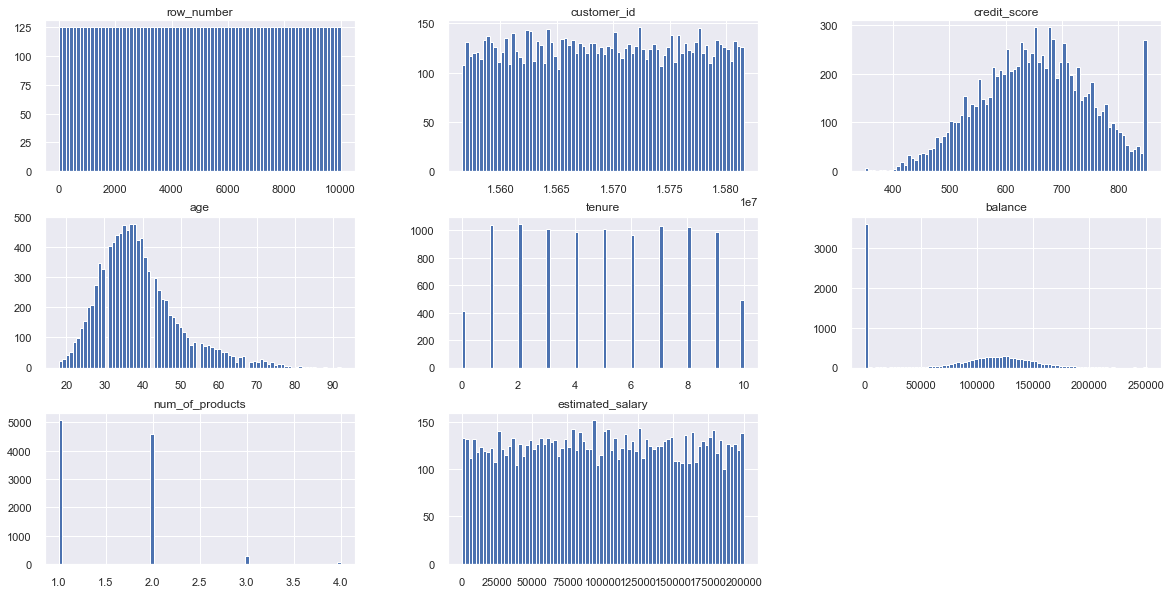

In [30]:
plt.rcParams['figure.figsize'] = [20, 10]

num_attributes.hist( bins=80 );

### 4.1.3. Categorical Variables

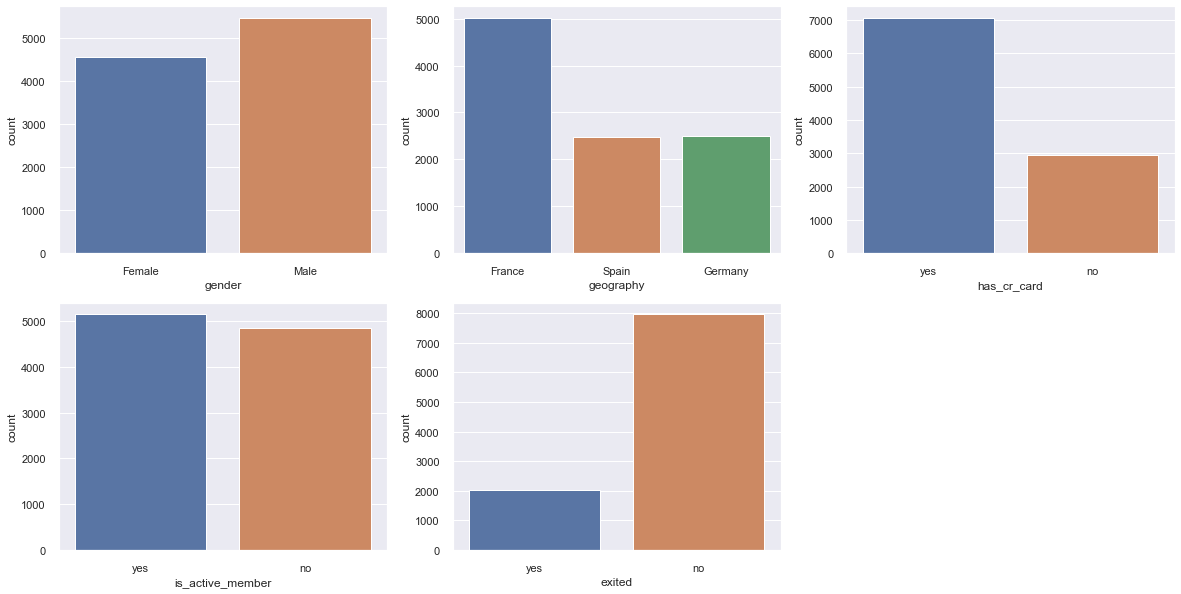

In [31]:
plt.figure( figsize=(20, 10) )
# gender plot
plt.subplot( 2,3,1 )
sns.countplot( x='gender', data=cat_attributes );

# geography plot
plt.subplot( 2,3,2 )
sns.countplot( x='geography', data=cat_attributes );

# has_cr_card plot
plt.subplot( 2,3,3 )
sns.countplot( x='has_cr_card', data=cat_attributes );

# is_active_member plot
plt.subplot( 2,3,4 )
sns.countplot( x='is_active_member', data=cat_attributes );

# exited plot
plt.subplot( 2,3,5 )
sns.countplot( x='exited', data=cat_attributes );

plt.show()

## 4.2. Bivariate Analysis

H1 - Younger customers tend to leave the bank easier - FALSE

In [32]:
df4.head()

,customer_id,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,credit_score_age,amount,credit_score_product,balance_age,balance_product,mean_salary,balance_scale
0,15634602,619,France,Female,42,2,0.00,1,yes,yes,101348.88,yes,14.738095,101348.88,619.000000,0.000000,0.000000,above average,zero
1,15647311,608,Spain,Female,41,1,83807.86,1,no,yes,112542.58,no,14.829268,196350.44,608.000000,2044.094146,83807.860000,above average,high_balance
2,15619304,502,France,Female,42,8,159660.80,3,yes,no,113931.57,yes,11.952381,273592.37,167.333333,3801.447619,53220.266667,above average,high_balance
3,15701354,699,France,Female,39,1,0.00,2,no,no,93826.63,no,17.923077,93826.63,349.500000,0.000000,0.000000,below average,zero
4,15737888,850,Spain,Female,43,2,125510.82,1,yes,yes,79084.10,no,19.767442,204594.92,850.000000,2918.856279,125510.820000,below average,high_balance


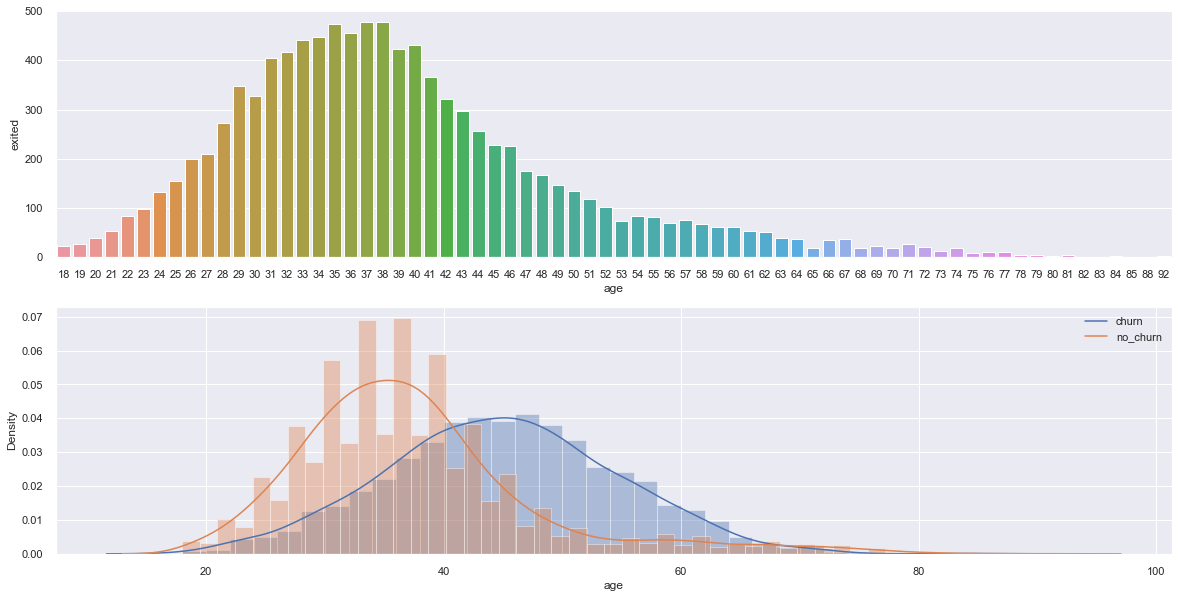

In [33]:
plt.subplot( 2,1,1 )

aux = df4[['age', 'exited']].groupby( 'age' ).count().reset_index()
sns.barplot( x='age', y='exited', data=aux );

plt.subplot( 2,1,2 )

sns.distplot( df4[df4['exited'] =='yes']['age'], label='churn' )
sns.distplot( df4[df4['exited'] =='no']['age'], label='churn' )
plt.legend( ['churn', 'no_churn'] )



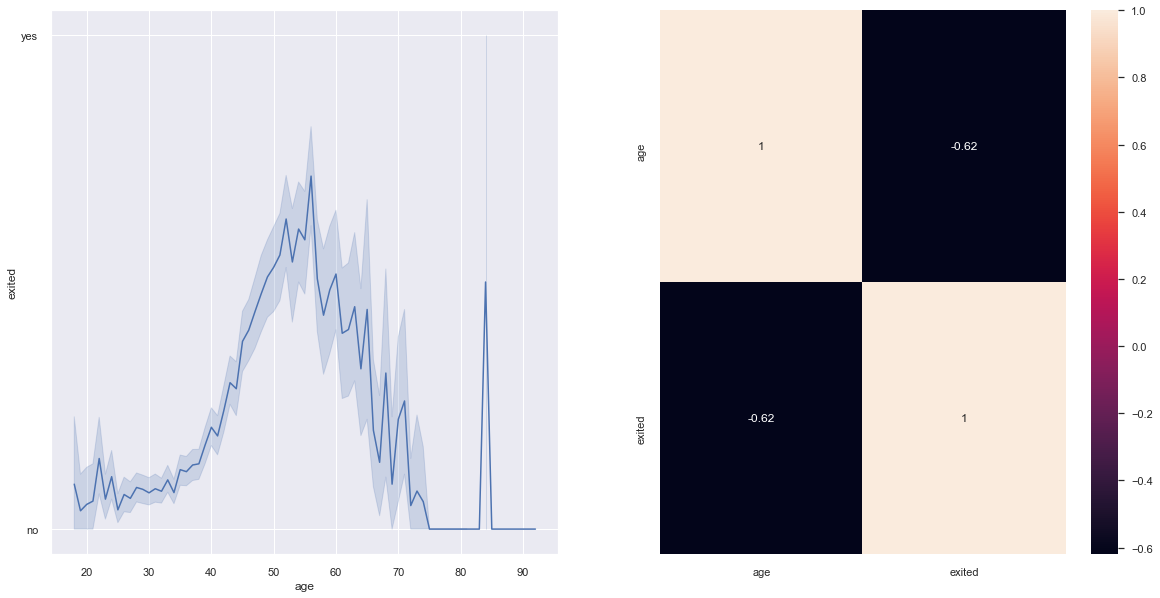

In [34]:
plt.subplot( 1,2,1 )
sns.lineplot( x='age', y='exited', data=df4 );

plt.subplot( 1,2,2 )
sns.heatmap( aux.corr( method='pearson' ), annot=True );

* **H2** - Customers with fewer products tend to leave the bank easier - TRUE

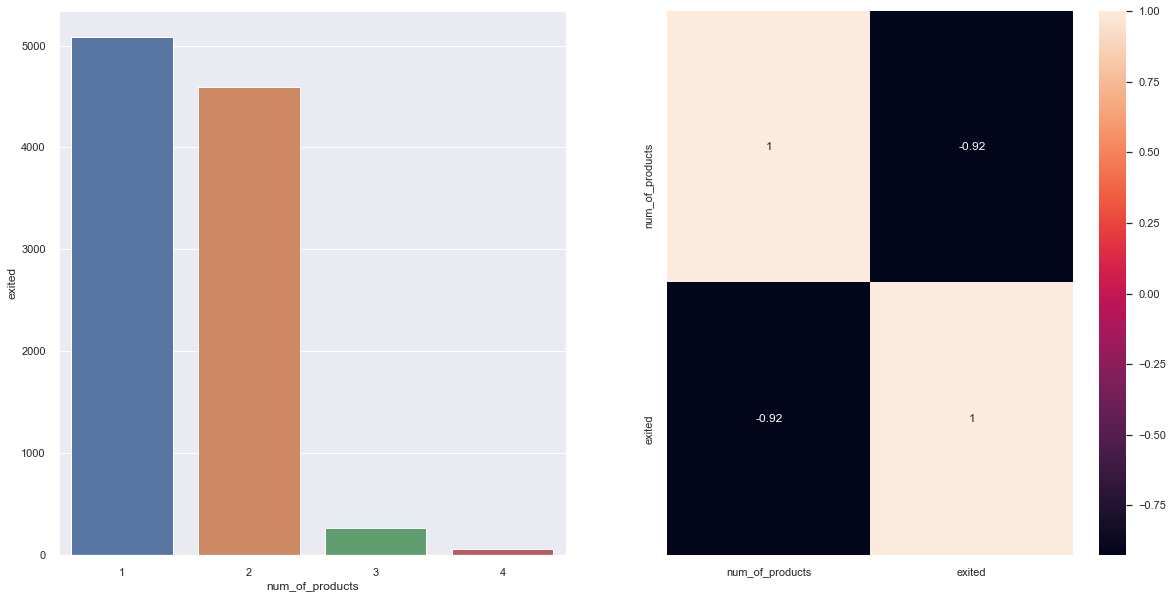

In [35]:
aux = df4[['num_of_products', 'exited']].groupby( 'num_of_products' ).count().reset_index()


#bar plot
plt.subplot( 1,2,1 )
sns.barplot( x='num_of_products', y='exited', data=aux );

# heat map
plt.subplot( 1,2,2 )
sns.heatmap( aux.corr( method='pearson' ), annot=True );



* **H3** - Customers without credit cards are more likely to churn - FALSE

<AxesSubplot:xlabel='has_cr_card', ylabel='exited'>

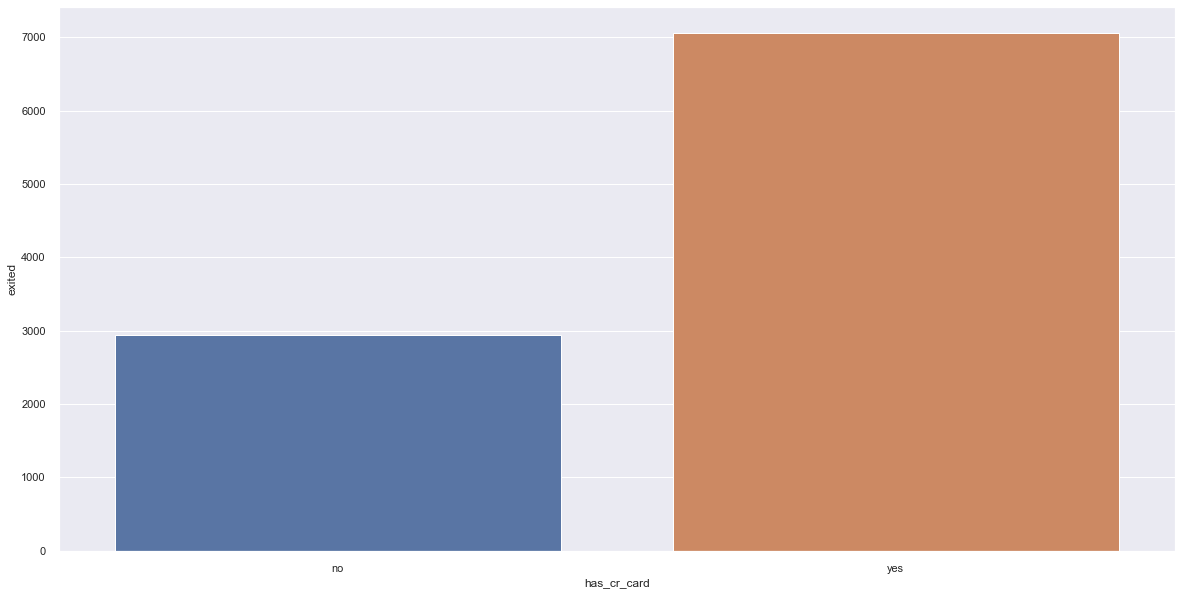

In [36]:
aux = df4[['has_cr_card', 'exited']].groupby( 'has_cr_card' ).count().reset_index()
sns.barplot( x='has_cr_card', y='exited', data=aux )

**H4** - people with high balance are more likely to churn - TRUE

<AxesSubplot:>

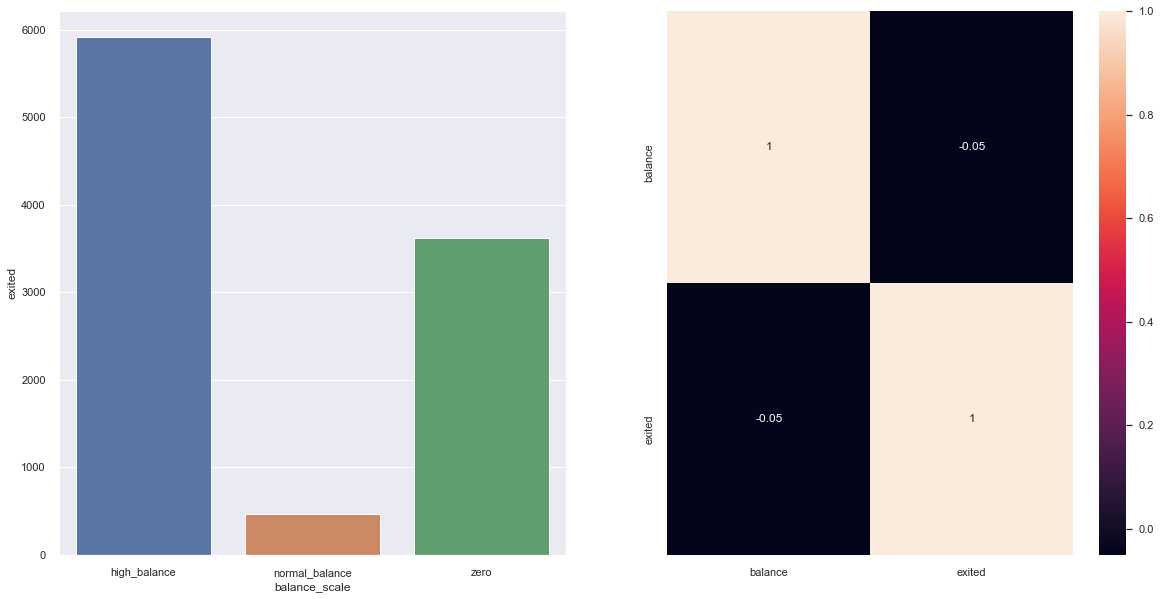

In [37]:
plt.subplot( 1,2,1 )

aux = df4[['balance_scale', 'exited']].groupby( 'balance_scale' ).count().reset_index().head()
sns.barplot( x='balance_scale', y='exited', data=aux )

plt.subplot( 1,2,2 )
aux1 = df4[['balance', 'exited']].groupby( 'balance' ).count().reset_index()
sns.heatmap( aux1.corr(), annot=True )

* **H5** - Active customers in the last 12 months have less chance of churn - inconclusive

In [38]:
aux = df4[['is_active_member', 'exited']].groupby( 'is_active_member' ).count().reset_index()
aux

,is_active_member,exited
0,no,4849
1,yes,5151


<AxesSubplot:xlabel='is_active_member', ylabel='exited'>

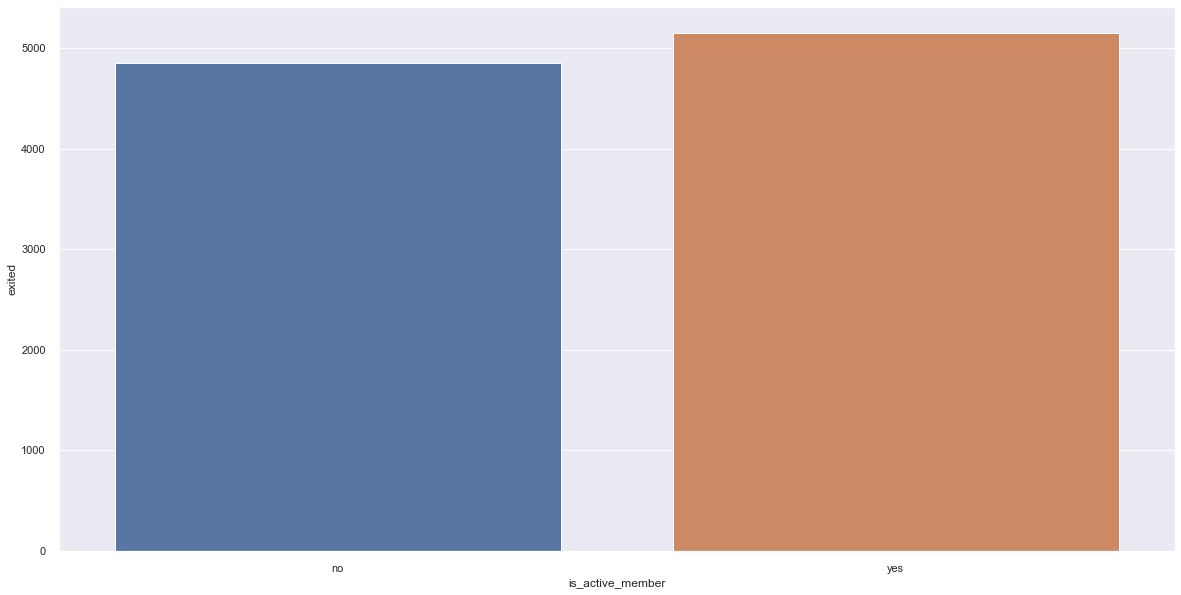

In [39]:
sns.barplot( x='is_active_member', y='exited', data=aux )

* **H6** - Salary below average (estimated_salary) greater chance of churn - Inconclusive

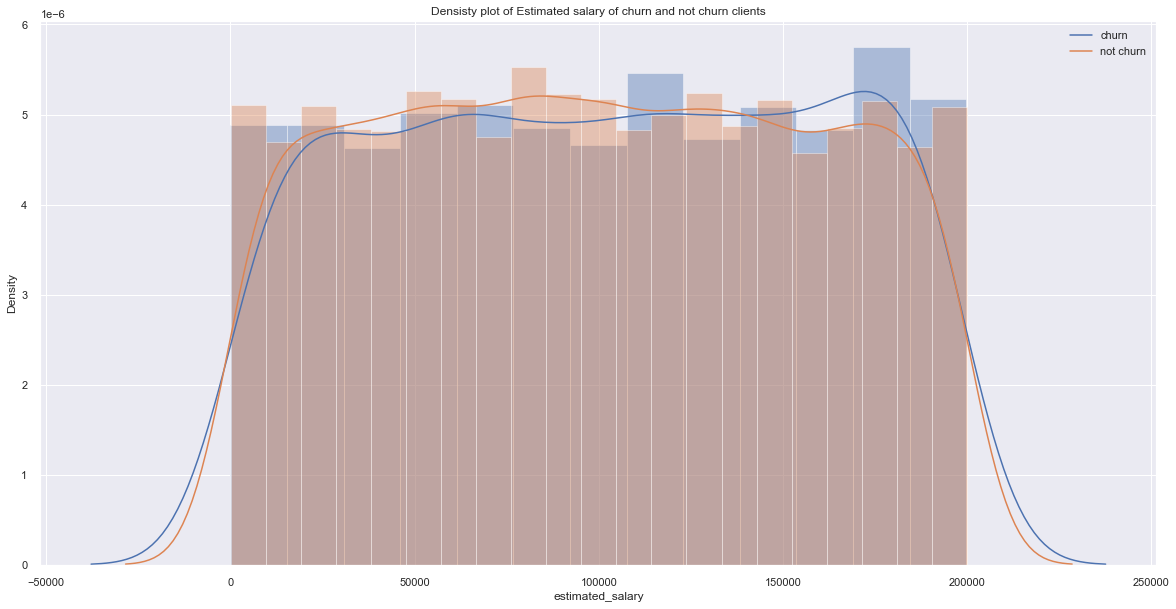

In [40]:
#Density plot of Estimated Salary of churn clients

sns.distplot(df4[df4['exited'] == 'yes']['estimated_salary'], label='churn') 
sns.distplot(df4[df4['exited'] == 'no']['estimated_salary'], label='not churn') 

plt.title('Densisty plot of Estimated salary of churn and not churn clients')
plt.legend(['churn', 'not churn']) ;

<AxesSubplot:>

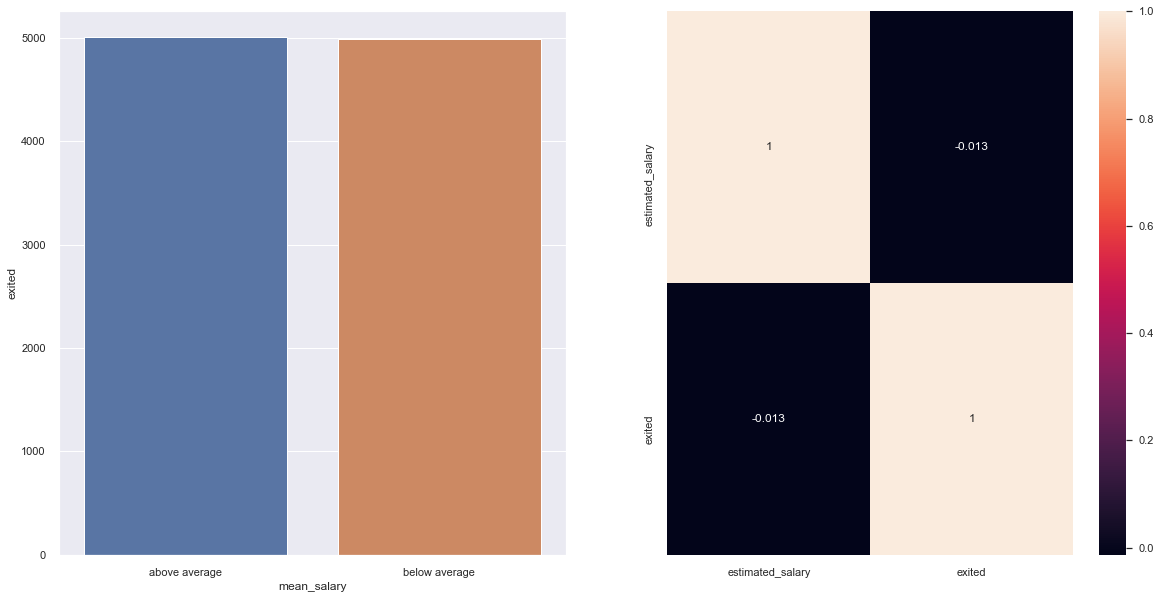

In [41]:
# mean_salary
plt.subplot( 1,2,1 )
aux = df4[['mean_salary', 'exited']].groupby( 'mean_salary' ).count().reset_index()
sns.barplot( x='mean_salary', y='exited', data=aux )


#heatmap
plt.subplot( 1,2,2 )
aux1 = df4[['estimated_salary', 'exited']].groupby( 'estimated_salary' ).count().reset_index()
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

* **H8** - Customers with a few years of banking (ternure) are more likely to churn - FALSE

<AxesSubplot:>

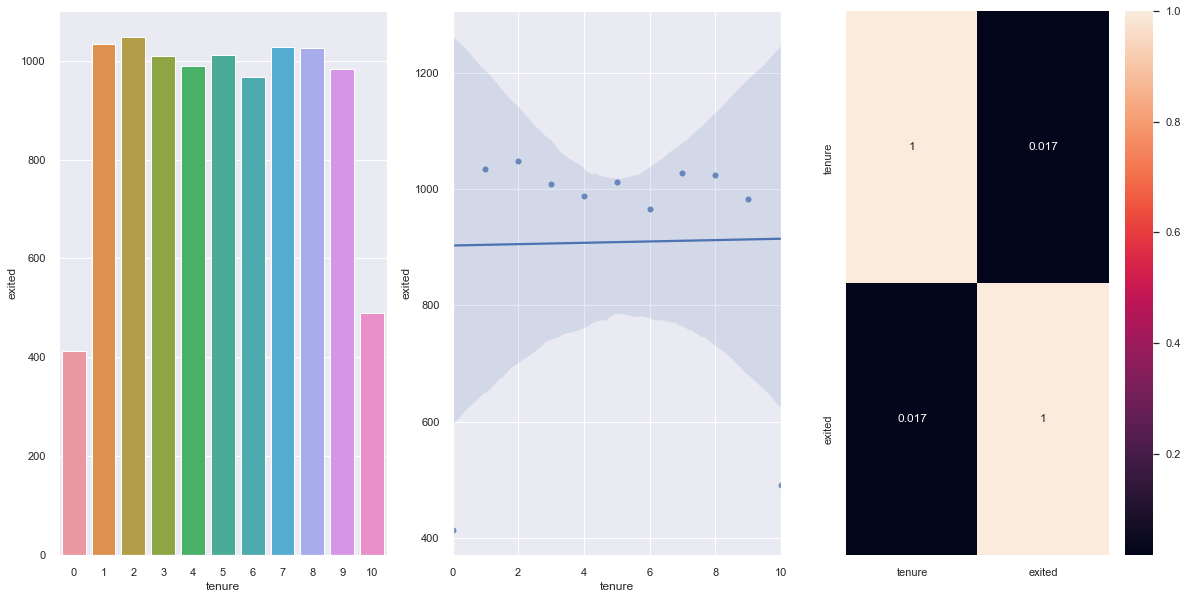

In [42]:
aux = df4[['tenure', 'exited']].groupby( 'tenure' ).count().reset_index()
plt.subplot( 1,3,1 )

sns.barplot( x='tenure', y='exited', data=aux )

plt.subplot( 1,3,2 )
sns.regplot( x='tenure', y='exited', data=aux )

plt.subplot( 1,3,3 )
sns.heatmap( aux.corr( method='pearson' ), annot=True )

* **H9** - Men are more likely to Churn- TRUE

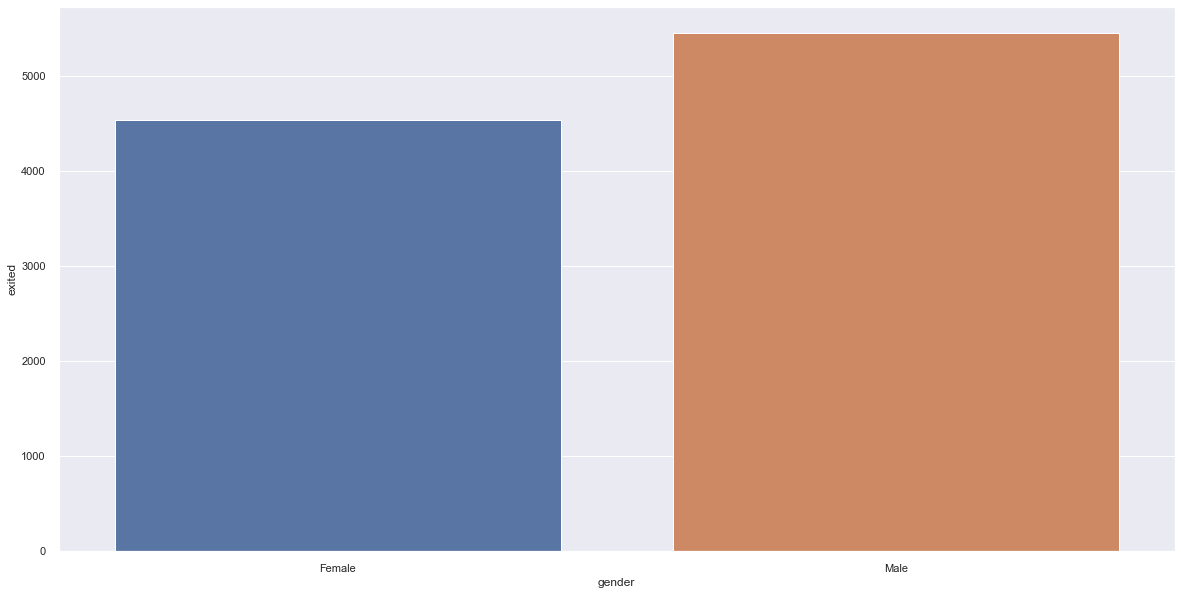

In [43]:
aux = df4[['gender', 'exited']].groupby( 'gender' ).count().reset_index()
sns.barplot( x='gender', y='exited', data=aux );

* **H10** - Customers with larger account amount have less chance of churn - TRUE

<AxesSubplot:>

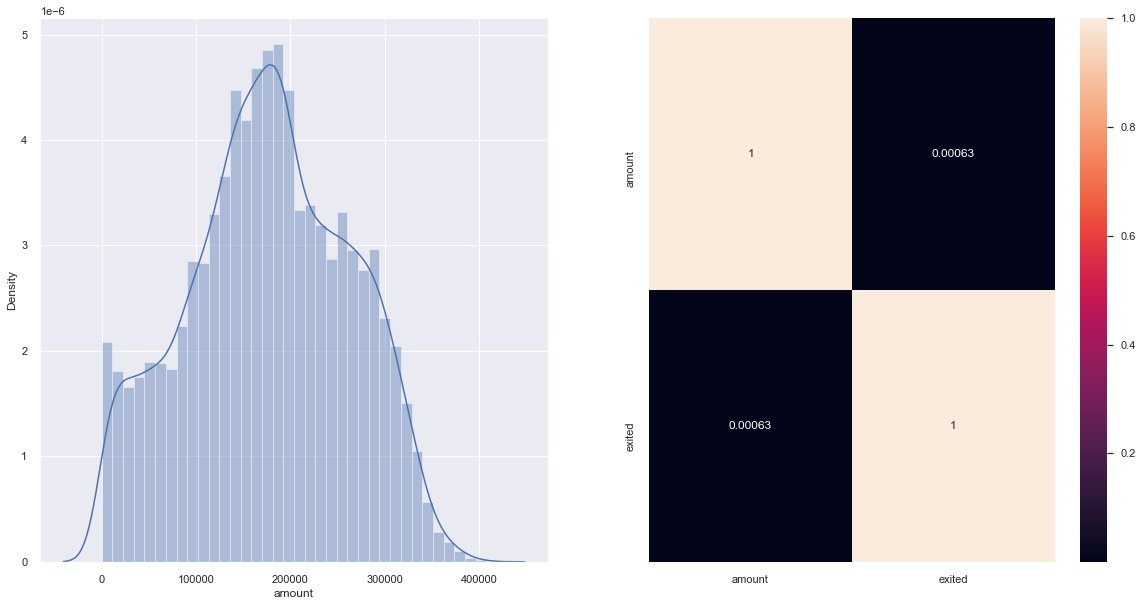

In [44]:
# distplot
plt.subplot( 1,2,1 )
aux = df4[['amount', 'exited']].groupby( 'amount' ).count().reset_index()
sns.distplot( df4['amount'] )

#heatmap
plt.subplot( 1,2,2 )
sns.heatmap( aux.corr( method='pearson' ), annot=True )

<AxesSubplot:>

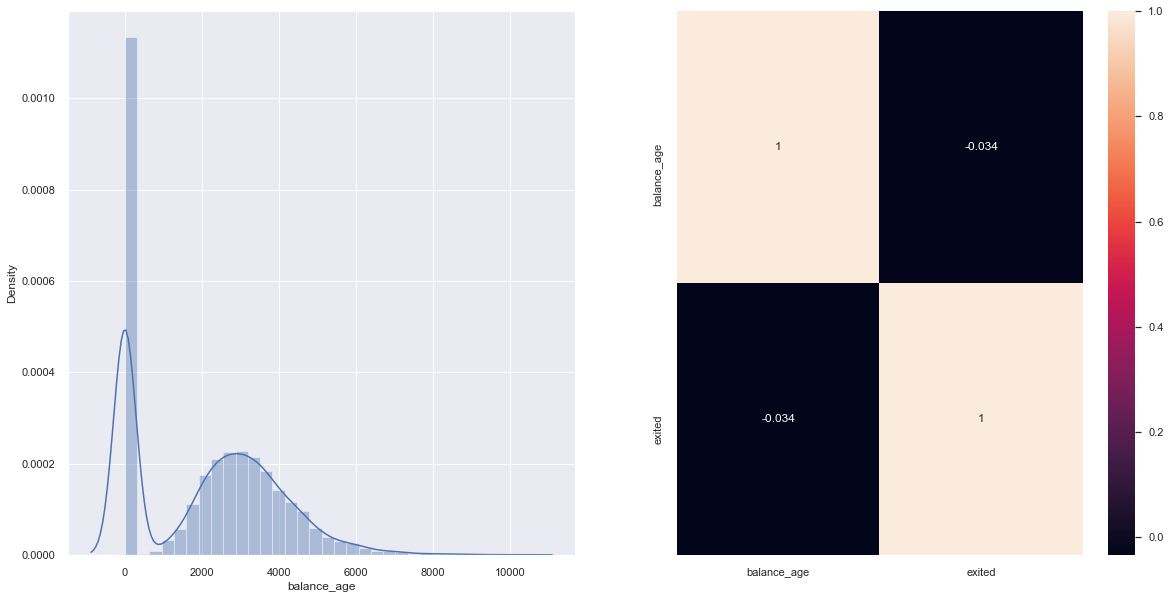

In [45]:

plt.subplot( 1,2,1 )
aux = df4[['balance_age', 'exited']].groupby( 'balance_age' ).count().reset_index()
sns.distplot( df4['balance_age'] )

plt.subplot( 1,2,2 )
sns.heatmap( aux.corr( method='pearson' ), annot=True )

## 4.3 Multivariate Analysis

### 4.3.1 Numerical atributes

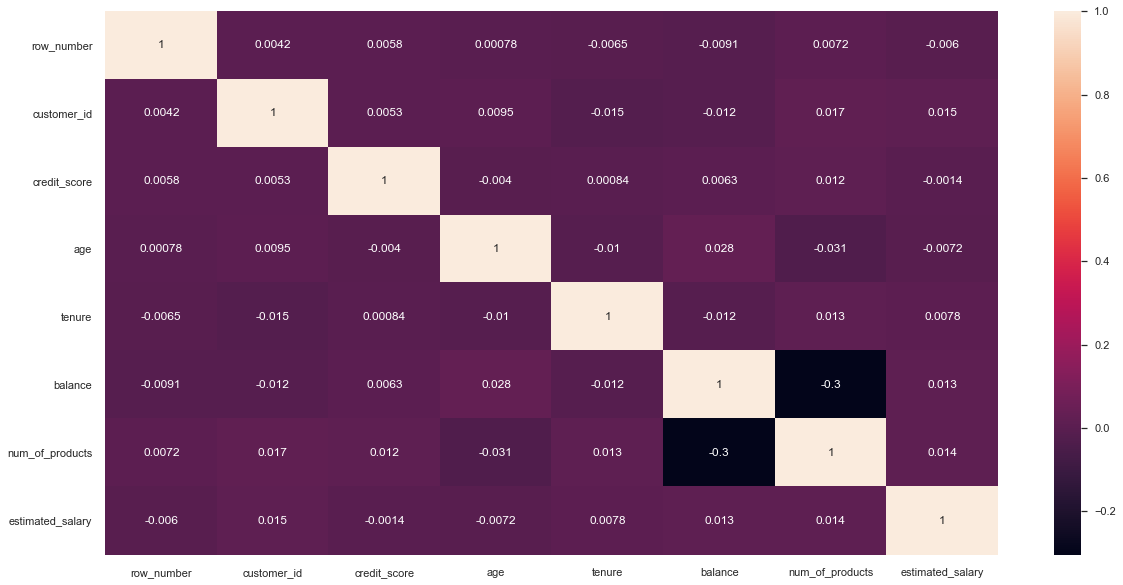

In [46]:
sns.heatmap( num_attributes.corr( method='pearson' ), annot=True );

### 4.3.2 Categorical attributes

In [47]:
#Select categorical data
df4['exited'] = df4['exited'].astype('str')

a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v( a['geography'], a['geography'] )
a2 = cramer_v( a['geography'], a['gender'] )
a3 = cramer_v( a['geography'], a['has_cr_card'] )
a4 = cramer_v( a['geography'], a['is_active_member'] )
a5 = cramer_v( a['geography'], a['exited'] )

a6 = cramer_v( a['gender'], a['geography'] )
a7 = cramer_v( a['gender'], a['gender'] )
a8 = cramer_v( a['gender'], a['has_cr_card'] )
a9 = cramer_v( a['gender'], a['is_active_member'] )
a10 = cramer_v( a['gender'], a['exited'] )

a11 = cramer_v( a['has_cr_card'], a['Geography'] )
a12 = cramer_v( a['has_cr_card'], a['Gender'] )
a13 = cramer_v( a['has_cr_card'], a['has_cr_card'] )
a14 = cramer_v( a['has_cr_card'], a['is_active_member'] )
a15 = cramer_v( a['has_cr_card'], a['exited'] )

a16 = cramer_v( a['is_active_member'], a['geography'] )
a17 = cramer_v( a['is_active_member'], a['gender'] )
a18 = cramer_v( a['is_active_member'], a['has_cr_card'] )
a19 = cramer_v( a['is_active_member'], a['is_active_member'] )
a20 = cramer_v( a['is_active_member'], a['exited'] )

a21 = cramer_v( a['exited'], a['geography'] )
a22 = cramer_v( a['exited'], a['gender'] )
a23 = cramer_v( a['exited'], a['has_cr_card'] )
a24 = cramer_v( a['exited'], a['is_active_member'] )
a25 = cramer_v( a['exited'], a['exited'] )

# Final dataset
d = pd.DataFrame( {'geography': [a1, a2, a3, a4, a5], 'gender': [a6, a7, a8, a9, a10], 'has_cr_card': [a11, a12, a13, a14, a15], 'is_active_member':[a16, a17, a18, a19, a20], 'exited':[a21, a22, a23, a24, a25]})                                                                         
d = d.set_index( d.columns )

#plt.rcParams['figure.figsize'] = [16, 6] #See if there is figuresize argument
sns.heatmap( d, annot=True, cmap='Reds') ;

AttributeError: module 'scipy' has no attribute 'chi2_contingency'

# 5.0 DATA PREPARATION

 The rescaling methods applied below are based on the features distribution shape and boxplot outlier analysis.

Standard Scaler: applied on variables with a distribution shape similar to a normal distribution;

Min-Max Scaler: applied on variables with low outliers influence;

Robust Scaler: applied on variables with high outliers influence.


In [47]:
df5 = df4.copy()

In [48]:
# credit_score - SS
# age - robust
# credit_score_age -robust
# balance_age - robust
# tenure - minmax
# balance - minmax
# estimated_salary - minmax
# amount - minmax
# credit_score_product - minmax
# balance_product - minmax

<AxesSubplot:xlabel='balance_product'>

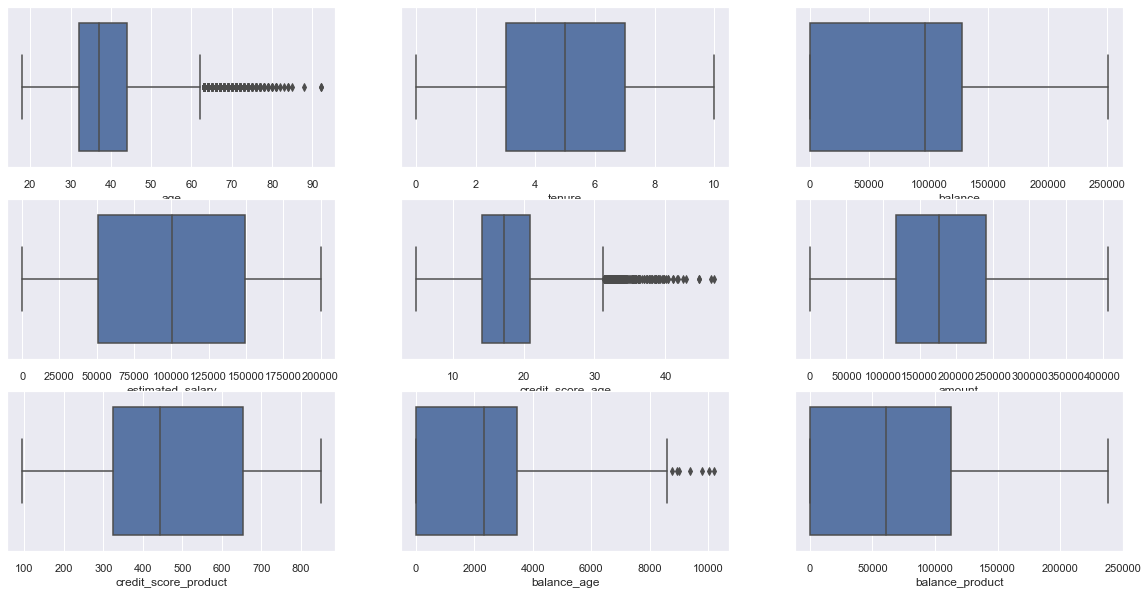

In [49]:
 # nrow,ncols,index
    
plt.subplot( 3, 3, 1 ) 

sns.boxplot( df5['age'] )

plt.subplot( 3, 3, 2 ) 

sns.boxplot( df5['tenure'] )

plt.subplot( 3, 3, 3 ) 
sns.boxplot( df5['balance'] )

plt.subplot( 3, 3, 4 ) 
sns.boxplot( df5['estimated_salary'] )

plt.subplot( 3, 3, 5 ) 
sns.boxplot( df5['credit_score_age'] )

plt.subplot( 3, 3, 6 ) 
sns.boxplot( df5['amount'] )

plt.subplot( 3, 3, 7 ) 
sns.boxplot( df5['credit_score_product'] )

plt.subplot( 3, 3, 8 ) 
sns.boxplot( df5['balance_age'] )

plt.subplot( 3, 3, 9 ) 
sns.boxplot( df5['balance_product'] )

In [50]:
# rollback yes, no columns 
cols = ['has_cr_card', 'is_active_member', 'exited' ]


for c in cols: 
    df5[c] = df5[c].apply( lambda x: 1 if x=='yes' else 0  )
    
    
for c in cols:
    df5[cols].astype( int64 )

## 5.1 Rescalling

In [52]:
# Standard Scaler
ss = StandardScaler()

# Min Max Scaler
mms = MinMaxScaler()

# Robust Scaler
rs = RobustScaler()

# Credit Score
df5['credit_score'] = ss.fit_transform( df5[['credit_score']].values )
pickle.dump( ss, open( '../parameter/credit_score_scaler.pkl', 'wb' ) )


# tenure
df5['tenure'] = mms.fit_transform( df5[['tenure']].values )
pickle.dump( mms, open( '../parameter/tenure_scaler.pkl', 'wb' ) )

# balance
df5['balance'] = mms.fit_transform( df5[['balance']].values )
pickle.dump( mms, open( '../parameter/balance_scaler.pkl', 'wb' ) )

# estimated_salary
df5['estimated_salary'] = mms.fit_transform( df5[['estimated_salary']].values )
pickle.dump( mms, open( '../parameter/estimated_salary_scaler.pkl', 'wb' ) )

# amount - minmax
df5['amount'] = mms.fit_transform( df5[['amount']].values )
pickle.dump( mms, open( '../parameter/amount_scaler.pkl', 'wb' ) )

# credit_score_product
df5['credit_score_product'] = mms.fit_transform( df5[['credit_score_product']].values )
pickle.dump( mms, open( '../parameter/credit_score_product_scaler.pkl', 'wb' ) )


# balance_product
df5['balance_product'] = mms.fit_transform( df5[['balance_product']].values )
pickle.dump( mms, open( '../parameter/balance_product_scaler.pkl', 'wb' ) )


# age 
df5['age'] = rs.fit_transform( df5[['age']].values )
pickle.dump( rs, open( '../parameter/age_scaler.pkl', 'wb' ) )


# credit_score_age
df5['credit_score_age'] = rs.fit_transform( df5[['credit_score_age']].values )
pickle.dump( rs, open( '../parameter/credit_score_age_scaler.pkl', 'wb' ) )


# balance_age
df5['balance_age'] = rs.fit_transform( df5[['balance_age']].values )
pickle.dump( rs, open( '../parameter/balance_age_scaler.pkl', 'wb' ) )

## 5.3 Transformation

### 5.3.1 Encoding

In [53]:
# Label enconding mean_salary
mean_salary_dict = {'above average': 1, 'below average': 2}
df5['mean_salary'] = df5['mean_salary'].map( mean_salary_dict )

# Label encoding balance_scale
balance_scale_dict = { 'zero': 0, 'high_balance': 1, 'normal_balance': 2 }
df5['balance_scale'] = df5['balance_scale'].map( balance_scale_dict )

# label encoding gender 
gender_dict = { 'Male':1 , 'Female':2 }
df5['gender'] = df5['gender'].map( gender_dict ) 

# One hot encoding encoding geography
df5 = pd.get_dummies( df5, prefix=['geo'], columns=['geography'] ) 

In [54]:
df5.head()

,customer_id,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,credit_score_age,amount,credit_score_product,balance_age,balance_product,mean_salary,balance_scale,geo_France,geo_Germany,geo_Spain
0,15634602,-0.326221,2,0.416667,0.2,0.000000,1,1,1,0.506735,1,-0.370690,0.248402,0.694444,-0.670999,0.000000,1,0,1,0,0
1,15647311,-0.440036,2,0.333333,0.1,0.334031,1,0,1,0.562709,0,-0.357423,0.481454,0.679894,-0.078670,0.351561,1,1,0,0,1
2,15619304,-1.536794,2,0.416667,0.8,0.636357,3,1,0,0.569654,1,-0.776023,0.670939,0.097002,0.430568,0.223251,1,1,1,0,0
3,15701354,0.501521,2,0.166667,0.1,0.000000,2,0,0,0.469120,0,0.092739,0.229949,0.337963,-0.670999,0.000000,2,0,1,0,0
4,15737888,2.063884,2,0.500000,0.2,0.500246,1,1,1,0.395400,0,0.361102,0.501679,1.000000,0.174815,0.526499,2,1,0,0,1


# 6.0 FEATURE SELECTION

In [55]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [56]:
# Remove customer_id. They will not be applied for the machine learning training.
df6 = df6.drop(['customer_id'], axis=1)

In [57]:
# Remove target variable from train set
X = df6.drop( 'exited', axis=1 )

y = df6['exited'].copy()

In [58]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=33 )

## 6.2 Boruta Feature Selector

In [59]:
# define random forest
rf = RandomForestRegressor( n_estimators = 100, n_jobs=-1)

# define boruta
boruta = BorutaPy( rf, n_estimators=100, verbose=2, random_state=33).fit( X_train.values, y_train.values.ravel() )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	16


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	16


In [60]:
cols_boruta = boruta.support_.tolist()

#best features
cols_selected = X_train.iloc[: , cols_boruta].columns.to_list()

#features not selected
cols_not_selected = list( np.setdiff1d( X_train.columns, cols_selected ))

## 6.3 Manual Selection

In [61]:
cols_selected

['age', 'num_of_products', 'is_active_member']

In [62]:
cols_selected.extend( ['estimated_salary' ,'amount', 'balance', 'credit_score', 'geo_Germany', 'geo_France', 'geo_Spain'] )

In [63]:
cols_selected

['age',
 'num_of_products',
 'is_active_member',
 'estimated_salary',
 'amount',
 'balance',
 'credit_score',
 'geo_Germany',
 'geo_France',
 'geo_Spain']

# 7.0 MACHINE LEARNING MODELING

In [64]:
from imblearn.combine import SMOTETomek 

In [65]:
# Imbalanced data
x_train = X_train[cols_selected]
x_test = X_test[cols_selected]

In [66]:
# Balanced data
# set the resampler
resampler = SMOTETomek(random_state=42, n_jobs=-1)

# resample the dataset
x_train_balanced, y_train_balanced = resampler.fit_resample(x_train, y_train)

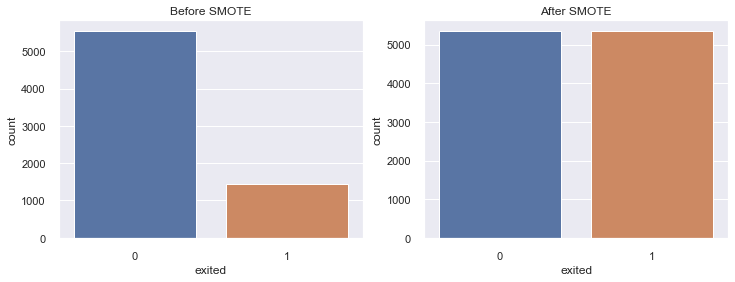

In [67]:
# plots before and after SMOTETomek
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title("Before SMOTE")

plt.subplot(1,2,2)
sns.countplot(x=y_train_balanced)
plt.title("After SMOTE")

plt.show()

## 7.1 Logistic Regression

In [68]:
# model
lr = LogisticRegression().fit( x_train, y_train )

# predict
yhat_logistic = lr.predict( x_test )

# performance
lr_result = scores( 'Logistic Regression', y_test, yhat_logistic )
lr_result

,Accuracy,Precision,recall,f1_score,roc_auc
Logistic Regression,0.812,0.562162,0.177172,0.26943,0.571802


### 7.1.1 Confusion Matrix

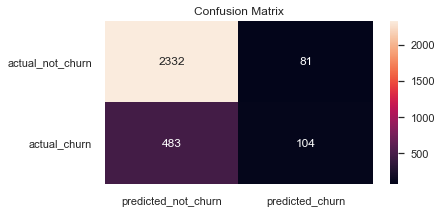

In [69]:
# confusion matrix
plt.figure( figsize=( 6,3 ) )
logistic_cm = confusion_matrix( y_test, yhat_logistic )
logistic_cm_df = pd.DataFrame( logistic_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'] )
sns.heatmap( logistic_cm_df, annot=True, fmt='d' ).set_title( 'Confusion Matrix' );

### 7.1.2 Logistic Regression Balanced

In [70]:
# model
lr_balanced = LogisticRegression().fit( x_train_balanced, y_train_balanced )

# predict
yhat_logistic_balanced = lr_balanced.predict( x_test )

# performance
lr_result_balanced = scores( 'Logistic Balanced', y_test, yhat_logistic_balanced )
lr_result_balanced

,Accuracy,Precision,recall,f1_score,roc_auc
Logistic Balanced,0.710333,0.36597,0.655877,0.469799,0.689729


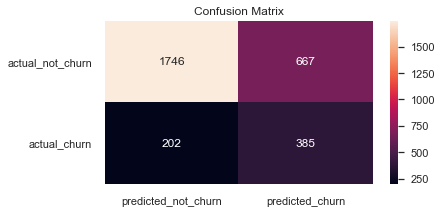

In [71]:
# confusion matrix
plt.figure( figsize=( 6,3 ) )
logistic_cm = confusion_matrix( y_test, yhat_logistic_balanced )
logistic_cm_df = pd.DataFrame( logistic_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'] )
sns.heatmap( logistic_cm_df, annot=True, fmt='d' ).set_title( 'Confusion Matrix' );

## 7.2 Random Forest Classifier

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
# model
rf = RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# predict
yhat_rf = rf.predict( x_test )


# performance
rf_result = scores( 'Random Forest', y_test, yhat_rf )
rf_result

,Accuracy,Precision,recall,f1_score,roc_auc
Random Forest,0.856333,0.69797,0.468484,0.560652,0.709584


### 7.2.1 Confusion Matrix

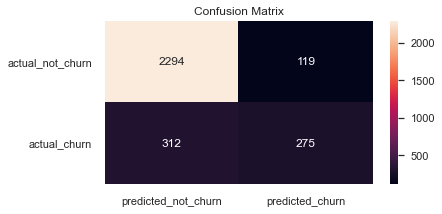

In [74]:
# confusion matrix
plt.figure( figsize=( 6,3 ) )
rf_cm = confusion_matrix( y_test, yhat_rf )
rf_cm_df = pd.DataFrame( rf_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'] )
sns.heatmap( rf_cm_df, annot=True, fmt='d' ).set_title( 'Confusion Matrix' );

### 7.2.2 Randon Forest Balanced

In [75]:
# model
rf_balanced = RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train_balanced, y_train_balanced )

# predict
yhat_rf_balanced = rf_balanced.predict( x_test )

# performance
rf_result_balanced = scores( 'Random Forest Balanced', y_test, yhat_rf_balanced )
rf_result_balanced

,Accuracy,Precision,recall,f1_score,roc_auc
Random Forest Balanced,0.82,0.536547,0.587734,0.560976,0.732118


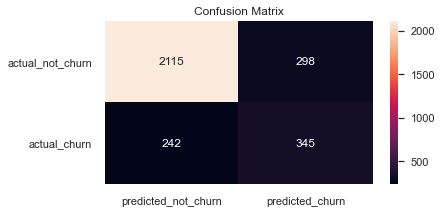

In [76]:
# confusion matrix
plt.figure( figsize=( 6,3 ) )
rf_cm = confusion_matrix( y_test, yhat_rf_balanced )
rf_cm_df = pd.DataFrame( rf_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'] )
sns.heatmap( rf_cm_df, annot=True, fmt='d' ).set_title( 'Confusion Matrix' );

## 7.3 XGBoost Classifier

In [77]:
from xgboost import XGBClassifier

In [78]:
# model
model_xgb = XGBClassifier(random_state=42, n_jobs=-1).fit(x_train, y_train)

# predict
yhat_xgb= model_xgb.predict( x_test )


# performance
xgb_result = scores( 'XGBoost Classifier', y_test, yhat_xgb )
xgb_result

,Accuracy,Precision,recall,f1_score,roc_auc
XGBoost Classifier,0.861,0.742857,0.44293,0.554963,0.702816


### 7.3.1 Confusion Matrix

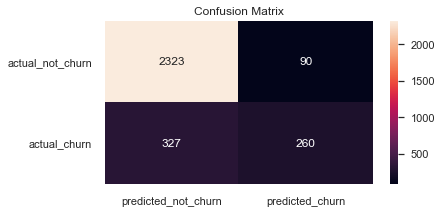

In [79]:
# confusion matrix
plt.figure( figsize=( 6,3 ) )
xgb_cm = confusion_matrix( y_test, yhat_xgb )
xgb_cm_df = pd.DataFrame( xgb_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'] )
sns.heatmap( xgb_cm_df, annot=True, fmt='d' ).set_title( 'Confusion Matrix' );

### 7.3.2 XGBoost Balanced

In [80]:
# model
model_xgb_balanced = XGBClassifier(random_state=42, n_jobs=-1).fit( x_train_balanced, y_train_balanced )

# predict
yhat_xgb_balanced = model_xgb_balanced.predict( x_test )

# Performance
xgb_result_balanced = scores( 'XGBoost Classifier Balanced', y_test, yhat_xgb_balanced )
xgb_result_balanced

,Accuracy,Precision,recall,f1_score,roc_auc
XGBoost Classifier Balanced,0.813333,0.516812,0.706985,0.597122,0.773094


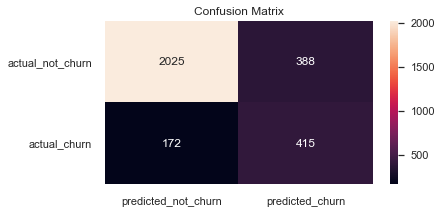

In [81]:
# confusion matrix
plt.figure( figsize=( 6,3 ) )
xgb_cm = confusion_matrix( y_test, yhat_xgb_balanced )
xgb_cm_df = pd.DataFrame( xgb_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'] )
sns.heatmap( xgb_cm_df, annot=True, fmt='d' ).set_title( 'Confusion Matrix' );

## 7.4 SVM

In [82]:
from sklearn.svm import SVC

In [83]:
# model
model_svm = SVC( random_state=42 ).fit( x_train, y_train )

# predict
yhat_svm = model_svm.predict( x_test )

# performance
svm_result = scores( 'SVM', y_test, yhat_svm )
svm_result

,Accuracy,Precision,recall,f1_score,roc_auc
SVM,0.858333,0.8,0.367973,0.504084,0.672797


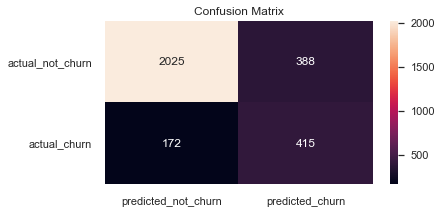

In [84]:
# confusion matrix
plt.figure( figsize=( 6,3 ) )
svm_cm = confusion_matrix( y_test, yhat_svm )
svm_cm_df = pd.DataFrame( svm_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'] )
sns.heatmap( xgb_cm_df, annot=True, fmt='d' ).set_title( 'Confusion Matrix' );

### 7.4.1 SVM Balanced

In [85]:
# model
model_svm_balanced = SVC( random_state=42 ).fit( x_train_balanced, y_train_balanced )

# predict
yhat_svm_balanced = model_svm.predict( x_test )

# performance
svm_result_balanced = scores( 'SVM Balanced', y_test, yhat_svm_balanced )
svm_result_balanced

,Accuracy,Precision,recall,f1_score,roc_auc
SVM Balanced,0.858333,0.8,0.367973,0.504084,0.672797


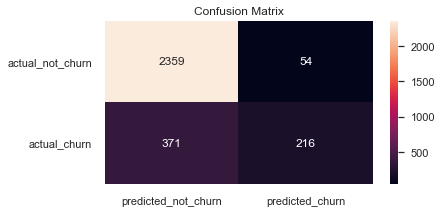

In [86]:
# confusion matrix
plt.figure( figsize=( 6,3 ) )
svm_cm = confusion_matrix( y_test, yhat_svm_balanced )
svm_cm_df = pd.DataFrame( svm_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'] )
sns.heatmap( svm_cm_df, annot=True, fmt='d' ).set_title( 'Confusion Matrix' );

## 7.6 Model Comparing

### 7.6.1 Imbalanced Data

In [87]:
results = pd.concat( [lr_result, rf_result, svm_result, xgb_result] ).sort_values( 'recall', ascending=True )
results

,Accuracy,Precision,recall,f1_score,roc_auc
Logistic Regression,0.812000,0.562162,0.177172,0.269430,0.571802
SVM,0.858333,0.800000,0.367973,0.504084,0.672797
XGBoost Classifier,0.861000,0.742857,0.442930,0.554963,0.702816
Random Forest,0.856333,0.697970,0.468484,0.560652,0.709584


### 7.6.2 Balanced Data

In [88]:
results_balanced = pd.concat( [lr_result_balanced, rf_result_balanced, svm_result_balanced, xgb_result_balanced] ).sort_values( 'recall', ascending=True )
results_balanced

,Accuracy,Precision,recall,f1_score,roc_auc
SVM Balanced,0.858333,0.800000,0.367973,0.504084,0.672797
Random Forest Balanced,0.820000,0.536547,0.587734,0.560976,0.732118
Logistic Balanced,0.710333,0.365970,0.655877,0.469799,0.689729
XGBoost Classifier Balanced,0.813333,0.516812,0.706985,0.597122,0.773094


### 7.6.1 ROC Curve Imbalanced Data

In [89]:
from yellowbrick.classifier import ROCAUC

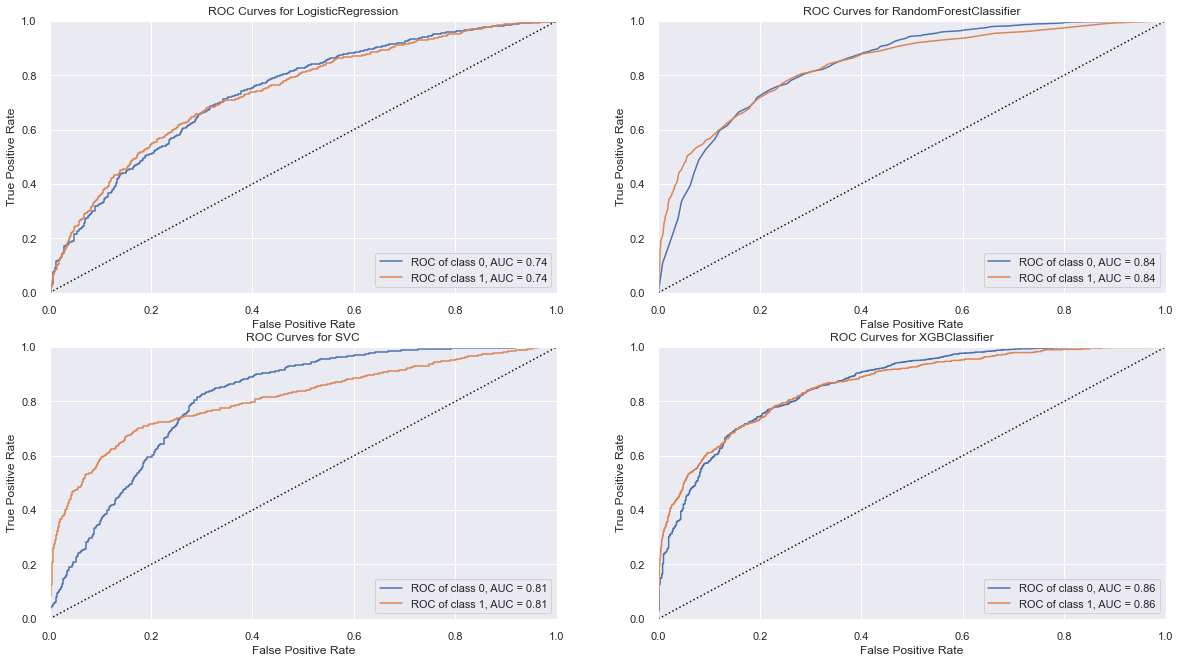

In [90]:
#ROC AUC ccurve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 11))

viz = ROCAUC( lr, iso_f1_curves=True, micro=False, macro=False, ax=ax1 )
viz.fit( x_train, y_train )
viz.score( x_test, y_test )
viz.finalize()

viz = ROCAUC( rf, iso_f1_curves=True, micro=False, macro=False, ax=ax2 )
viz.fit( x_train, y_train )
viz.score( x_test, y_test )
viz.finalize()

viz = ROCAUC( model_svm, iso_f1_curves=True, micro=False, macro=False, ax=ax3 )
viz.fit( x_train, y_train )
viz.score( x_test, y_test )
viz.finalize()

viz = ROCAUC( model_xgb, iso_f1_curves=True, micro=False, macro=False, ax=ax4 )
viz.fit( x_train, y_train )
viz.score( x_test, y_test )
viz.finalize()

### 7.6.2 ROC Curve Balanced Data

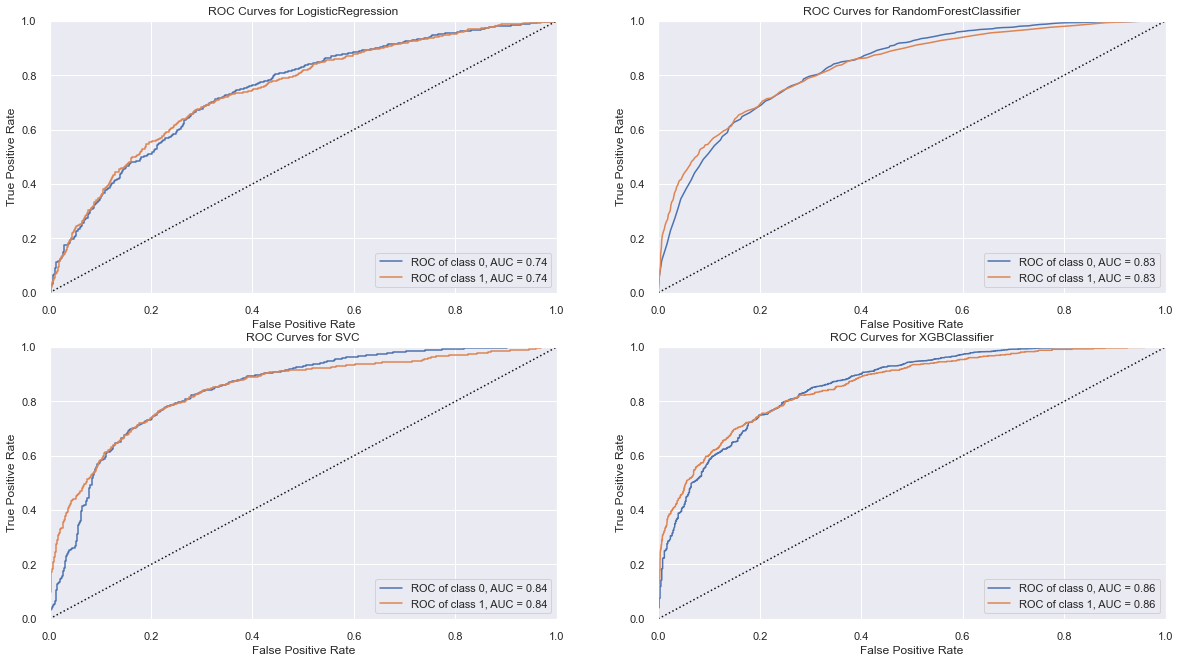

In [91]:
#ROC AUC ccurve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 11))

viz = ROCAUC( lr_balanced, iso_f1_curves=True, micro=False, macro=False, ax=ax1 )
viz.fit( x_train, y_train )
viz.score( x_test, y_test )
viz.finalize()

viz = ROCAUC( rf_balanced, iso_f1_curves=True, micro=False, macro=False, ax=ax2 )
viz.fit( x_train, y_train )
viz.score( x_test, y_test )
viz.finalize()

viz = ROCAUC( model_svm_balanced, iso_f1_curves=True, micro=False, macro=False, ax=ax3 )
viz.fit( x_train, y_train )
viz.score( x_test, y_test )
viz.finalize()

viz = ROCAUC( model_xgb_balanced, iso_f1_curves=True, micro=False, macro=False, ax=ax4 )
viz.fit( x_train, y_train )
viz.score( x_test, y_test )
viz.finalize()

# 8.0 HYPERPARAMETER FINE TUNNING

In [92]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.svm import SVC as svc 
from sklearn.metrics import make_scorer, roc_auc_score
from scipy import stats
 

In [93]:
# parameters for random search
#param_grid = {
#   'n_estimators': [1500, 1700, 2500, 3000, 3500],
#   'eta': [0.01, 0.03],
#   'max_depth = [int(x) for x in np.linspace(4, 40, 10)],
#   'subsample': [0.1, 0.5, 0.7],
#   'colsample_bytree': [0.3, 0.7, 0.9],
#   'min_child_weight': [3, 8, 15]       
#}

In [94]:
# model definition
#model_xgb = XGBClassifier(random_state=42, n_jobs=-1)

# random search
#model_xgb_tuned = RandomizedSearchCV(estimator=model_xgb, param_distributions=param_grid,
#                              scoring='f1', n_iter=50, cv=10, verbose=2,
#                              random_state=42, n_jobs=-1)

# model training
#model_xgb_tuned.fit( x_train, y_train )

# random search Best Parameters
#model_xgb_tuned.best_params_

In [95]:
model_xgb_tuned = XGBClassifier(colsample_bytree=0.7, eta=0.01, max_depth=8, min_child_weight=15,
              min_samples_leaf=2, min_samples_split=2, n_jobs=-1,
              random_state=42).fit( x_train_balanced, y_train_balanced )

yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

result = scores( 'XGB tuned', y_test, yhat_xgb_tuned )
result

,Accuracy,Precision,recall,f1_score,roc_auc
XGB tuned,0.828667,0.556414,0.613288,0.583468,0.747174


In [96]:
# {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 1.0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__subsample': 0.9}

In [97]:
model_xgb_tuned = XGBClassifier(colsample_bytree=1.0, gamma=1.0, learning_rate=0.1, max_depth=4, min_child_weight=5, subsample=0.9  ).fit( x_train_balanced, y_train_balanced )

yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

result = scores( 'XGB tuned', y_test, yhat_xgb_tuned )
result

,Accuracy,Precision,recall,f1_score,roc_auc
XGB tuned,0.821,0.53406,0.667802,0.59349,0.763035


In [98]:
y_train_proba = cross_val_predict(model_xgb_tuned, x_train, y=y_train, cv=10, n_jobs=-1, method='predict_proba')[:, 1]

In [99]:
y_test_proba = model_xgb_tuned.predict_proba(x_test)[:, 1]

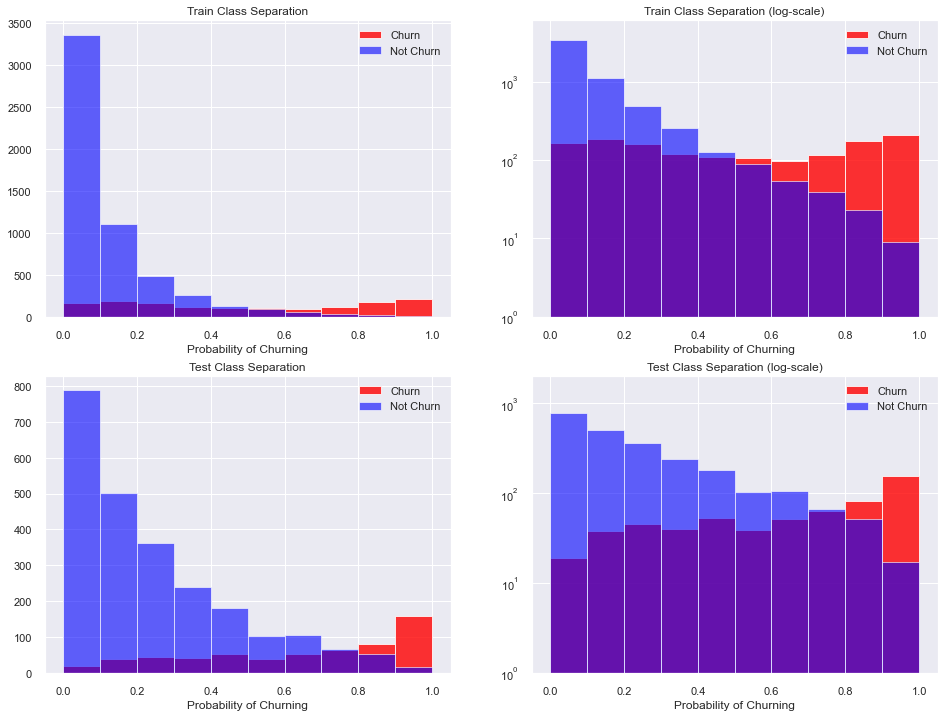

In [100]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
(ax1, ax2), (ax3, ax4) = ax

bins = np.arange(0, 1.1, .1)
ax1.hist(y_train_proba[y_train.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8)
ax1.hist(y_train_proba[~y_train.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6)
ax1.set_title('Train Class Separation')
ax1.set_xlabel('Probability of Churning')
ax1.legend()

ax2.hist(y_train_proba[y_train.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax2.hist(y_train_proba[~y_train.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax2.set_title('Train Class Separation (log-scale)')
ax2.set_xlabel('Probability of Churning')
ax2.set_ylim(1, 6000)
ax2.legend()

bins = np.arange(0, 1.1, .1)
ax3.hist(y_test_proba[y_test.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8)
ax3.hist(y_test_proba[~y_test.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6)
ax3.set_title('Test Class Separation')
ax3.set_xlabel('Probability of Churning')
ax3.legend()

ax4.hist(y_test_proba[y_test.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax4.hist(y_test_proba[~y_test.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax4.set_title('Test Class Separation (log-scale)')
ax4.set_xlabel('Probability of Churning')
ax4.set_ylim(1, 2000)
ax4.legend()
plt.show()

# 9.0 ERROR INTERPRETATION

 In this section, we answer the initial business questions we had based on the analysis done in the Exploratory Data Analysis portion and evaluate the model's performance in financial terms.

###  Q1. What is the bank's current Churn rate?

In [101]:
churn_rate = round( (df5[df5['exited'] == 1]['exited'].count()/len(df5))*100,2 )
print( 'The curent churn rate is {}%'.format(churn_rate) )

The curent churn rate is 20.37%


*  How the churn rate varies per month?

In [102]:
total_members    =  df5.loc[df5['is_active_member'],['is_active_member']].sum()
active_members   = df5.loc[df5['is_active_member'] == 1, ['is_active_member']].sum()
churn_year_rate  = (active_members/total_members) *100
churn_month_rate = churn_year_rate/12
churn_month_rate

is_active_member    4.2925
dtype: float64

In [103]:
print('The churn month rate is: 4.29%')

The churn month rate is: 4.29%


 ### 9.2.3 What is the expected return, in terms of revenue, if the company uses its model to avoid customer churn?

##  5.1 Simulation -  Discount cupom of \$100

In [104]:
salary_mean = round( df1['estimated_salary'].mean(), 2)
salary_mean

100090.24

In [105]:
#Predict probabilities
y_proba = pd.DataFrame(model_xgb_tuned.predict_proba(x_test))

#Transform into DataFrame

y_test = y_test.to_frame()

In [106]:
 #Get the Estimated Salary information

bal = x_test[['estimated_salary']]

bal['estimated_salary'] = mms.inverse_transform(bal[['estimated_salary']].values)

exited_bal = pd.concat((y_test, bal), axis=1)

In [107]:
#Merge DataFrames

exited_bal.reset_index(drop=True, inplace=True)

pred = pd.concat((exited_bal, y_proba), axis=1)

pred.drop([0], axis=1, inplace=True)

In [108]:
#Sort by probability to churn

pred.sort_values(by=1, inplace=True, ascending=False)

In [109]:
#Get the top 100 probabilities

top_100 = pred.head(100)

In [110]:
#Proportion of sucess - percentage

a = top_100['exited'].value_counts(normalize=True)*100

a.to_frame()

,exited
1,92.0
0,8.0


In [111]:
#Proportion of sucess - absolute values

false_churn = top_100['exited'].value_counts()

false_churn.to_frame()

,exited
1,92
0,8


In [112]:
#Create above average column

top_100['above_average'] = top_100['estimated_salary']

top_100['above_average'] = top_100['above_average'].apply(lambda x: 'yes' if x >= salary_mean else 'no')

In [113]:
#Above average overall statistics

a = top_100.pivot_table(values='exited', columns='above_average', aggfunc='count')

a

above_average,no,yes
exited,42,58


In [114]:
#Create DataFrame for true churns

true_100 = top_100[top_100['exited'] == 1]

true_100.shape

(92, 4)

In [115]:
#Calculate the estimate return for each client 

true_100['100_return'] = true_100['estimated_salary']

true_100['100_return'] = true_100['100_return'].apply(lambda x: x*0.20 if x>= salary_mean else x*0.15)

In [116]:
 #Results - if 100% of clients returned

return_100 = (true_100['100_return'].sum()).round()

waste_100 = false_churn[0] * 100

print('If all churn clients were recovered: $', return_100)
print('Clients that were not actual churn (waste): $',waste_100)

If all churn clients were recovered: $ 1992966.0
Clients that were not actual churn (waste): $ 800


In [117]:
#Scenario analysis

#Pessimistic
p_recovered = (return_100 * 0.7).round()
print('Pessimistic - recovered: $', p_recovered)

#Realistic
r_recovered = (return_100 * 0.8).round()
print('Realistic - recovered: $', r_recovered)

#Optmistic
o_recovered = (return_100 * 0.9).round()
print('Optmistic - recovered: $', o_recovered)

#Mean
mean = ((p_recovered + p_recovered + p_recovered) / 3).round()
print('Mean of scenarios - recovered: $', mean)

Pessimistic - recovered: $ 1395076.0
Realistic - recovered: $ 1594373.0
Optmistic - recovered: $ 1793669.0
Mean of scenarios - recovered: $ 1395076.0


##  5.2 Simulation -  Discount cupom of \$50

In [118]:
# se o desconto for de $ 50 então nosso budget irá para os top200 customers

# Get the top 200 probabilities

top_200 = pred.head(200)

# Proportion of sucess - percentage

aux = top_200['exited'].value_counts(normalize=True)*100

aux.to_frame()

,exited
1,88.5
0,11.5


In [119]:
#Proportion of sucess - absolute values

false_churn = top_200['exited'].value_counts()

false_churn.to_frame()

,exited
1,177
0,23


In [120]:
top_200['above_average'] = top_200['estimated_salary']


top_200['above_average'] = top_200['above_average'].apply( lambda x: 'yes' if x >= x>=salary_mean else 'no')


In [121]:
#Above average overall statistics

a = top_200.pivot_table(values='exited', columns='above_average', aggfunc='count')

a

above_average,no,yes
exited,73,127


In [122]:
# create a DataFrame for the true Churns
true_200 = top_200[top_200['exited'] == 1]
true_200.shape

(177, 4)

In [123]:
# Calculate the estimate return for each client 
true_200['200_return'] = true_200['estimated_salary']

true_200['200_return'] = true_200['200_return'].apply(lambda x: x*0.20 if x>=salary_mean else x*0.15)

In [124]:
#Results - if 100% of clients returned

return_200 = (true_200['200_return'].sum()).round()

waste_200 = false_churn[0] * 50

print('If all churn clients were recovered: $', return_200)
print('Clients that were not actual churn (waste): $',waste_200)

If all churn clients were recovered: $ 4239817.0
Clients that were not actual churn (waste): $ 1150


In [125]:
#Scenario analysis

#Pessimistic
p_recovered = (return_200 * 0.4).round()
print('Pessimistic - recovered: $', p_recovered)

#Realistic
r_recovered = (return_200 * 0.5).round()
print('Realistic - recovered: $', r_recovered)

#Optmistic
o_recovered = (return_200 * 0.6).round()
print('Optmistic - recovered: $', o_recovered)

#Mean
mean = ((p_recovered + r_recovered + o_recovered) / 3).round()
print('Mean of scenarios - recovered: $', mean)

Pessimistic - recovered: $ 1695927.0
Realistic - recovered: $ 2119908.0
Optmistic - recovered: $ 2543890.0
Mean of scenarios - recovered: $ 2119908.0


##  5.3 Simulation -  Discount cupom of \$25

In [126]:
# se o desconto for de $ 25 então nosso budget irá para os top_400 customers

top_400 = pred.head(400)

# percentage of churn top400
aux = top_400['exited'].value_counts( normalize=True )*100
aux.to_frame()

,exited
1,71.25
0,28.75


In [127]:
#Proportion of sucess - absolute values

false_churn = top_400['exited'].value_counts()

false_churn.to_frame()

,exited
1,285
0,115


In [128]:
# Create above average column
top_400['above_average'] = top_400['estimated_salary']
top_400['above_average'] = top_400['above_average'].apply( lambda x: 'yes' if x>=salary_mean else 'no' )

#Above average overall statistics

aux = top_400.pivot_table(values='exited', columns='above_average', aggfunc='count')

aux

above_average,no,yes
exited,157,243


In [129]:
 # Create DataFrame for true churns
true_400 = top_400[top_400['exited'] == 1]

# Calculate the estimate return for each customer
true_400['400_return'] = true_400['estimated_salary']
true_400['400_return'] = true_400['400_return'].apply( lambda x: x*0.20 if x>=salary_mean else x*0.15  )

#Results - if 100% of clients returned

return_400 = (true_400['400_return'].sum()).round()

waste_400 = false_churn[0] * 25

print('If all churn clients were recovered: $', return_400)
print('Clients that were not actual churn (waste): $',waste_400)

If all churn clients were recovered: $ 6645660.0
Clients that were not actual churn (waste): $ 2875


In [130]:
#Scenario analysis

#Pessimistic
p_recovered = (return_400 * 0.3).round()
print('Pessimistic - recovered: $', p_recovered)

#Realistic
r_recovered = (return_400 * 0.4).round()
print('Realistic - recovered: $', r_recovered)

#Optmistic
o_recovered = (return_400 * 0.5).round()
print('Optmistic - recovered: $', o_recovered)

#Mean
mean = ((p_recovered + r_recovered + o_recovered) / 3).round()
print('Mean of scenarios - recovered: $', mean)

Pessimistic - recovered: $ 1993698.0
Realistic - recovered: $ 2658264.0
Optmistic - recovered: $ 3322830.0
Mean of scenarios - recovered: $ 2658264.0


## 9.4. ROI(Return on Investiment)

In [131]:
# Mean Return
ticket_100 = 1395076
ticket_50  = 2119908
ticket_25  = 2658264

#ROI calculation

ROI_100 = round(( ticket_100 / 10000) * 100 )

ROI_50 = round(( ticket_50 / 10000) * 100 )

ROI_25 = round(( ticket_25 / 10000) * 100 )

print('ROI $100:', ROI_100)
print('ROI $50:', ROI_50)
print('ROI $25:', ROI_25)

ROI $100: 13951
ROI $50: 21199
ROI $25: 26583


# 10.0 DEPLOY MODEL TO PRODUCTION

In [132]:
import pickle

In [133]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open('../models/model_churn_predict.pkl', 'wb') )

## 10.1. ChurnClass

In [134]:
import pickle
import inflection
import numpy as np
import pandas as pd


class Churn( object ):
    def __init__( self ):
        self.home_path = r'C:\Users\Cliente\repos\pa003_churn_predict\churn_predict\parameter'
        self.credit_score_scaler     = pickle.load( open( self.home_path + '/credit_score_scaler.pkl', 'rb' ) )
        self.ternure_scaler          = pickle.load( open( self.home_path + '/tenure_scaler.pkl', 'rb' ) )
        self.balance_scaler          = pickle.load( open( self.home_path + '/balance_scaler.pkl', 'rb' ) )
        self.estimated_salary_scaler = pickle.load( open( self.home_path + '/estimated_salary_scaler.pkl', 'rb' ) )
        self.amount_scaler           = pickle.load( open( self.home_path + '/amount_scaler.pkl', 'rb' ) )
        self.credit_score_product    = pickle.load( open( self.home_path + '/credit_score_product_scaler.pkl', 'rb' ) )
        self.balance_product_scaler  = pickle.load( open( self.home_path + '/balance_product_scaler.pkl', 'rb' ) )
        self.age_scaler              = pickle.load( open( self.home_path + '/age_scaler.pkl', 'rb' ) )
        self.credit_score_age_scaler = pickle.load( open( self.home_path + '/credit_score_age_scaler.pkl', 'rb' ) )
        self.balance_age_scaler      = pickle.load( open( self.home_path + '/balance_age_scaler.pkl', 'rb' ) )


    
    def data_cleaning( self, df1 ):    

        ## 1.1 Rename columns

        cols_old = df1.columns

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map ( snakecase, cols_old ) )
        # rename
        df1.columns = cols_new
        
        return df1


    def feature_engineering( self, df2 ):
    
        # Credit score per age
        df2['credit_score_age'] = df2['credit_score'] / df2['age']

        # amount = estimated_salary + balance
        df2['amount'] = df2['estimated_salary'] + df2['balance']

        # Credit score per product
        df2['credit_score_product'] = df2['credit_score'] / df2['num_of_products']

        # balance per age
        df2['balance_age'] = df2['balance'] / df2['age']

        # balance per number of products
        df2['balance_product'] = df2['balance'] / df2['num_of_products']

        # Mean Salary
        mean_salary = np.mean( df2['estimated_salary'].values)
        df2['mean_salary'] = df2['estimated_salary'].apply( lambda x: 'below average' if x < mean_salary else 'average' if x==mean_salary else 'above average'  )

        # Balance scale
        df2['balance_scale'] = df2['balance'].apply( lambda x: 'zero' if x==0 else 'normal_balance' if (x > 0) & (x <= 76485.89) else 'high_balance' )

        # 3.0 VARIABLE SELECTION

        df2 = df2.drop( ['row_number','surname'], axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.1 Rescalling
        # Credit Score
        df5['credit_score'] = self.credit_score_scaler.fit_transform( df5[['credit_score']].values )

        # tenure
        df5['tenure'] = self.ternure_scaler.fit_transform( df5[['tenure']].values )

        # balance
        df5['balance'] = self.balance_scaler.fit_transform( df5[['balance']].values )

        # estimated_salary
        df5['estimated_salary'] = self.estimated_salary_scaler.fit_transform( df5[['estimated_salary']].values )

        # amount - minmax
        df5['amount'] = self.amount_scaler.fit_transform( df5[['amount']].values )

        # credit_score_product
        df5['credit_score_product'] = self.credit_score_product.fit_transform( df5[['credit_score_product']].values )

        # balance_product
        df5['balance_product'] = self.balance_product_scaler.fit_transform( df5[['balance_product']].values )

        # age 
        df5['age'] = self.age_scaler.fit_transform( df5[['age']].values )

        # credit_score_age
        df5['credit_score_age'] = self.credit_score_age_scaler.fit_transform( df5[['credit_score_age']].values )

        # balance_age
        df5['balance_age'] = self.balance_age_scaler.fit_transform( df5[['balance_age']].values )

        ## 5.3 Transformation

        ### 5.3.1 Encoding

        # Label enconding mean_salary
        mean_salary_dict = {'above average': 1, 'below average': 2}
        df5['mean_salary'] = df5['mean_salary'].map( mean_salary_dict )

        # Label encoding balance_scale
        balance_scale_dict = { 'zero': 0, 'high_balance': 1, 'normal_balance': 2 }
        df5['balance_scale'] = df5['balance_scale'].map( balance_scale_dict )

        # label encoding gender 
        gender_dict = { 'Male':1 , 'Female':2 }
        df5['gender'] = df5['gender'].map( gender_dict ) 

        # One hot encoding encoding geography
        df5 = pd.get_dummies( df5, prefix=['geo'], columns=['geography'] ) 
        
        # Selected colunms
        cols_selected = ['age', 'num_of_products', 'is_active_member', 'estimated_salary', 'amount', 'balance', 'credit_score', 'geo_Germany', 'geo_France', 'geo_Spain']
        
        return df5[cols_selected]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict_proba( test_data )
        
        # join pred into the original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )
      



## 10.2. API Handler

In [142]:
import pickle
import pandas as pd
from churn.Churn import Churn
from flask       import Flask, request, Response

# loading model
model = pickle.load( open( r'C:\Users\Cliente\repos\pa003_churn_predict\churn_predict\models\model_churn.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/churn/predict', methods=['POST'] )
def churn_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Churn Class
        pipeline = Churn()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        #feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_preparation( model, test_raw, df3 )
        
        return df_response
        
            
            
    else:
        return Response( '{}', status=200, mimetype='application/json' )


if __name__ == '__main__':
    app.run( '0.0.0.0' )
    

ModuleNotFoundError: No module named 'churn'

## 10.3. API Tester

In [145]:
df10 = pd.read_csv( '../data/raw/churn.csv' )

In [146]:
# convert Dataframe to json
data = json.dumps( df10.to_dict( orient='records' ) )

In [147]:
import requests

In [148]:
#url = 'http://127.0.0.1:5000/churn/predict'
url = 'https://churn-model-prediction.herokuapp.com/churn/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url=url, data=data, headers=header)
print( 'Status Code {}'. format( r.status_code ) )

Status Code 200


In [150]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [151]:
d1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,credit_score_age,amount,credit_score_product,balance_age,balance_product,mean_salary,balance_scale,prediction
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,14.738095,101348.88,619.000000,0.000000,0.000000,above average,zero,0.513271
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,14.829268,196350.44,608.000000,2044.094146,83807.860000,above average,high_balance,0.254725
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,11.952381,273592.37,167.333333,3801.447619,53220.266667,above average,high_balance,0.980506
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,17.923077,93826.63,349.500000,0.000000,0.000000,below average,zero,0.121753
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,19.767442,204594.92,850.000000,2918.856279,125510.820000,below average,high_balance,0.235492


In [153]:
d1.to_excel('predictions.xlsx')